In [ ]:
import json
import re
import csv
import random
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict, Tuple, Set
from collections import defaultdict
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [2]:
with open('TVs-all-merged.json', 'r') as file:
    data = json.load(file)

In [3]:
# Flatten the JSON structure
flattened_data = []
for model, details in data.items():
    for entry in details:
        entry_flat = {
            "modelID": model,
            "shop": entry["shop"],
            "title": entry["title"],
            "features": entry["featuresMap"]
        }
        flattened_data.append(entry_flat)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(flattened_data)

In [5]:
df.head(5)

,modelID,shop,title,features
0,29PFL4508/F7,bestbuy.com,"Philips 4000 Series 29"" Class 2812"" Diag. LED ...","{'Screen Size Class': '29""', 'DVI Inputs': '0'..."
1,SC-3211,newegg.com,"Newegg.com - SuperSonic 32"" 720p LED HDTV SC-3211","{'Headphone': 'Yes', 'Remote Control': 'Full F..."
2,LC-90LE657U,bestbuy.com,"Sharp AQUOS 90"" Class 90"" Diag. LED 1080p 120H...","{'Language Options': 'English, French, Spanish..."
3,39PFL2908/F7,bestbuy.com,"Philips 2000 Series 39"" Class 3858"" Diag. LED ...",{'Meta Title': 'Philips Electronics 39PFL2908'...
4,LC70LE550U,newegg.com,"Newegg.com - Sharp Aquos 70"" Class (69.5"" Diag...","{'Remote Control': 'Yes', 'Series': 'Aquos', '..."


# Data Cleaning

In [6]:
# Function to clean features that have an additional ":"
def clean_feature_names_semicolon(features):
    if isinstance(features, dict):
        cleaned_features = {}
        for key, value in features.items():
            cleaned_key = key.rstrip(':')  # Remove trailing colons
            cleaned_features[cleaned_key] = value
        return cleaned_features
    return features  # Return as is if not a dictionary

In [ ]:
# Apply cleaning to the 'featuresMap' column
df['features'] = df['features'].apply(clean_feature_names_semicolon)


             modelID         shop  \
0       29PFL4508/F7  bestbuy.com   
1            SC-3211   newegg.com   
2        LC-90LE657U  bestbuy.com   
3       39PFL2908/F7  bestbuy.com   
4         LC70LE550U   newegg.com   
...              ...          ...   
1619      TC-P55GT31  bestbuy.com   
1620  UN40EH5000FXZA  bestbuy.com   
1621  UN40EH5000FXZA   newegg.com   
1622    NS-32E859A11  bestbuy.com   
1623            E424  bestbuy.com   

                                                  title  \
0     Philips 4000 Series 29" Class 2812" Diag. LED ...   
1     Newegg.com - SuperSonic 32" 720p LED HDTV SC-3211   
2     Sharp AQUOS 90" Class 90" Diag. LED 1080p 120H...   
3     Philips 2000 Series 39" Class 3858" Diag. LED ...   
4     Newegg.com - Sharp Aquos 70" Class (69.5" Diag...   
...                                                 ...   
1619  Panasonic - VIERA 55"  Class / Plasma / 1080p ...   
1620  Samsung 40" Class 40" Diag. LED 1080p 60Hz HDT...   
1621  Samsung 40" Class 

In [8]:
# Extract the 'features' column
features_list = df['features']

# Create a set to collect all unique feature keys
unique_features = set()

# Iterate over all rows in 'features' to extract keys
for features in features_list:
    if isinstance(features, dict):  # Ensure the value is a dictionary
        unique_features.update(features.keys())

# Convert to a sorted list for better readability
unique_features = sorted(unique_features)
print(f"Total Unique Features: {len(unique_features)}")
print("List of Features:")
print(unique_features)

Total Unique Features: 324
List of Features:
['3-D Glasses Included', '3-D Ready', '3D Glasses Required', '3D Technology', '3D Type', '3D-Ready', '3DTV', 'A/V Outputs', 'AM/FM Tuner', 'ASIN', 'Additional Information', 'Alarm Timer', 'Analog Audio', 'Analog Tuner', 'Antenna Included', 'Antiglare Coating', 'Aspect Ratio', 'Assembly Required', 'Audio Outputs', 'BD Live', 'Backlight System', 'Backlight Technology', 'Batteries', 'Battery Included', 'Best Buy Exclusive', 'Best Sellers Rank', 'Blu Ray Combo', 'Bluetooth', 'Box Dimensions', 'Brand', 'Brand Name', 'Brightness', 'Built-In Player', 'Built-in Speakers', 'Cabinet Color', 'Capacity', 'Certifications & Standards', 'Channel Labeling', 'Color', 'Color Name', 'Color Supported', 'Comb Filter', 'Combo Player', 'Compatibility', 'Compatible Models', 'Component Video', 'Component Video Inputs', 'Component Video Outputs', 'Composite A/V', 'Composite Inputs', 'Composite Video', 'Composite Video Inputs', 'Connectors', 'Contrast Ratio', 'DLNA', 

In [9]:
with open("unique_features.txt", "w") as file:
    for feature in sorted(unique_features):  # Sort for better readability
        file.write(feature + "\n")

In [10]:
from collections import Counter

# Count occurrences of each feature
feature_counts = Counter()
for features in features_list:
    if isinstance(features, dict):  # Ensure the value is a dictionary
        feature_counts.update(features.keys())

# Convert to a DataFrame for easier visualization
feature_counts_df = pd.DataFrame(feature_counts.items(), columns=['Feature', 'Count'])
feature_counts_df = feature_counts_df.sort_values(by='Count', ascending=False)

# Display the feature occurrence counts
print(feature_counts_df)


                          Feature  Count
24             Maximum Resolution   1076
14                   Aspect Ratio    940
50                          Brand    867
10                            UPC    773
8                          V-Chip    757
..                            ...    ...
191  Vertical Keystone Correction      1
192          Parts Warranty/Labor      1
193                   Form Factor      1
194            Number of Speakers      1
323               HDMI Connection      1

[324 rows x 2 columns]


In [20]:
# Regex normalization rules for the title


normalization_rules = {
    r'(?<=\d)"': ' inch',                # Replace `"` with ` inch` if it follows a digit
    r'\b(inch|inches|("|“|”|`|-inch| inch))\b': 'inch',  # Normalize "inch" variations
    r'(?<=\d)(hz|hertz)': ' hz',         # Replace `Hz` or `Hertz` with ` hz` if preceded by a digit
}

# Function to normalize text using regex rules
def normalize_title(title, rules):
    if isinstance(title, str):
        for pattern, replacement in rules.items():
            title = re.sub(pattern, replacement, title, flags=re.IGNORECASE)
        return title
    return title  # Return as is if not a string


In [ ]:
# Regex normalization rule for the features 

# Function to normalize text using regex rules
def normalize_text(text, rules):
    if isinstance(text, str):
        for pattern, replacement in rules.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
        return text.strip()  # Clean up extra spaces
    return text  # Return as is if not a string

# Function to normalize features (both keys and values)
def normalize_features(features, rules):
    if isinstance(features, dict):
        normalized_features = {}
        for key, value in features.items():
            normalized_key = normalize_text(key, rules).lower()  # Normalize keys to lowercase
            normalized_value = normalize_text(value, rules) if isinstance(value, str) else value  # Normalize values
            normalized_features[normalized_key] = normalized_value
        return normalized_features
    return features


In [15]:
normalization_rules = {
    r'(?<=\d)"': ' inch',
    r'\b(inch|inches|("|“|”|`|-inch| inch))\b': 'inch',
    r'(?<=\d)(hz|hertz)': ' hz',
}

def clean_model_word(word: str) -> str:
    # Convert all 'pound', 'pounds', 'lbs', 'lb' to 'lb'
    word = re.sub(r'\b(pounds?|lbs?)\b', 'lb', word, flags=re.IGNORECASE)
    
    # Remove internal spaces
    word = word.replace(" ", "")
    
    # Normalize decimals by removing trailing zeros
    # If word is a number with optional decimal
    if re.match(r'^\d+(\.\d+)?$', word):
        val = float(word)
        s = str(val)
        # Remove trailing .0 if present
        if s.endswith('.0'):
            s = s[:-2]
        word = s
    
    return word

def normalize_title_string(title: str, rules: dict) -> str:
    if isinstance(title, str):
        # Apply original regex normalization rules
        for pattern, replacement in rules.items():
            title = re.sub(pattern, replacement, title, flags=re.IGNORECASE)
        title = title.strip()
        
        # Split into tokens and apply new cleaning steps
        tokens = title.split()
        cleaned_tokens = [clean_model_word(t) for t in tokens]
        return " ".join(cleaned_tokens)
    return title

def normalize_text(text: str, rules: dict) -> str:
    if isinstance(text, str):
        for pattern, replacement in rules.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
        return text.strip()
    return text

def normalize_features_dict(features: dict, rules: dict) -> dict:
    if isinstance(features, dict):
        normalized_features = {}
        for key, value in features.items():
            # Only original rules for features, no new cleaning steps
            normalized_key = normalize_text(key, rules).lower()
            normalized_value = normalize_text(value, rules) if isinstance(value, str) else value
            normalized_features[normalized_key] = normalized_value
        return normalized_features
    return features

def normalize_title_column(df, title_col='title', rules=normalization_rules):
    # This function applies both original and new cleaning steps to the title
    df['normalized_title'] = df[title_col].apply(lambda x: normalize_title_string(x, rules))
    return df

def normalize_features_column(df, features_col='features', rules=normalization_rules):
    # This function applies only the original rules to the features, no new cleaning steps
    df['normalized_features'] = df[features_col].apply(lambda x: normalize_features_dict(x, rules))
    return df

In [16]:
df = normalize_title_column(df, title_col='title', rules=normalization_rules)
df = normalize_features_column(df, features_col='features', rules=normalization_rules)

In [17]:
df.head(5)

,modelID,shop,title,features,normalized_title,normalized_features
0,29PFL4508/F7,bestbuy.com,"Philips 4000 Series 29"" Class 2812"" Diag. LED ...","{'Screen Size Class': '29""', 'DVI Inputs': '0'...",Philips 4000 Series 29inch Class 2812inch Diag...,"{'screen size class': '29inch', 'dvi inputs': ..."
1,SC-3211,newegg.com,"Newegg.com - SuperSonic 32"" 720p LED HDTV SC-3211","{'Headphone': 'Yes', 'Remote Control': 'Full F...",Newegg.com - SuperSonic 32inch 720p LED HDTV S...,"{'headphone': 'Yes', 'remote control': 'Full F..."
2,LC-90LE657U,bestbuy.com,"Sharp AQUOS 90"" Class 90"" Diag. LED 1080p 120H...","{'Language Options': 'English, French, Spanish...",Sharp AQUOS 90inch Class 90inch Diag. LED 1080...,"{'language options': 'English, French, Spanish..."
3,39PFL2908/F7,bestbuy.com,"Philips 2000 Series 39"" Class 3858"" Diag. LED ...",{'Meta Title': 'Philips Electronics 39PFL2908'...,Philips 2000 Series 39inch Class 3858inch Diag...,{'meta title': 'Philips Electronics 39PFL2908'...
4,LC70LE550U,newegg.com,"Newegg.com - Sharp Aquos 70"" Class (69.5"" Diag...","{'Remote Control': 'Yes', 'Series': 'Aquos', '...",Newegg.com - Sharp Aquos 70inch Class (69.5inc...,"{'remote control': 'Yes', 'series': 'Aquos', '..."


In [ ]:
# Product class to easily extract title, modelID etc. in the rest of the pipeline
class Product:
    def __init__(self, title, modelID, shop, url, featuresMap):
        self.title = title
        self.modelID = modelID
        self.shop = shop
        self.url = url
        self.featuresMap = featuresMap

    def __repr__(self):
        return f"Product(title={self.title}, modelID={self.modelID}, shop={self.shop}, url={self.url}, featuresMap={self.featuresMap})"
    

# TF-IDF selection of features

In [21]:
def tokenize_features(features_map: dict) -> str:
    """
    Tokenize and concatenate all feature values in a featuresMap dictionary.

    :param features_map: Dictionary of features.
    :return: Concatenated string of feature values.
    """
    tokens = []
    for key, value in features_map.items():
        # Normalize text by removing special characters and converting to lowercase
        value = re.sub(r'[^\w\s]', '', value.lower())
        tokens.append(value)
    return " ".join(tokens)

In [22]:
def generate_tfidf_matrix(products: List[Product]) -> TfidfVectorizer:
    """
    Generate a TF-IDF matrix for all products' features.

    :param products: List of Product objects.
    :return: TF-IDF vectorizer fitted on the features.
    """
    feature_texts = [tokenize_features(product.featuresMap) for product in products]
    vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features globally
    tfidf_matrix = vectorizer.fit_transform(feature_texts)
    return vectorizer, tfidf_matrix


In [53]:
def filter_features_by_tfidf(product_idx: int, vectorizer: TfidfVectorizer, tfidf_matrix, original_features: dict, top_n) -> dict:
    """
    Filter features for a product based on the top N TF-IDF scores, retaining the original features and values.

    :param product_idx: Index of the product in the TF-IDF matrix.
    :param vectorizer: TF-IDF vectorizer.
    :param tfidf_matrix: Sparse TF-IDF matrix.
    :param original_features: Original featuresMap dictionary for the product.
    :param top_n: Number of top features to retain.
    :return: Filtered features map with original keys and values.
    """
    # Get feature names and the product's TF-IDF vector
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix[product_idx].toarray()[0]

    # Get the top N features by score
    top_indices = scores.argsort()[-top_n:][::-1]
    top_features = {feature_names[i]: scores[i] for i in top_indices if scores[i] > 0}

    # Retain only the original features that correspond to the top TF-IDF terms
    filtered_features = {}
    for key, value in original_features.items():
        key_tokens = set(re.sub(r'[^\w\s]', '', key.lower()).split())  # Tokenize the key
        if any(token in top_features for token in key_tokens):  # Check if the key matches a top feature
            filtered_features[key] = value

    return filtered_features




In [54]:
def load_data_with_tfidf(df, top_n_features) -> Tuple[List[Product], np.ndarray]:
    """
    Load data and preprocess features using TF-IDF to reduce feature count, while retaining original featuresMap structure.

    :param df: Normalized DataFrame containing product information.
    :param top_n_features: Number of top features to retain per product.
    :return: A tuple (list of Product objects, duplicates_matrix).
    """
    # Extract products
    products: List[Product] = [
        Product(
            title=row['normalized_title'].replace("/", "").strip(),
            modelID=row['modelID'],
            shop=row['shop'],
            url=row.get('url', ''),  # Handle cases where 'url' may not be present
            featuresMap=row['normalized_features']
        )
        for _, row in df.iterrows()
    ]

    # Generate TF-IDF matrix
    vectorizer, tfidf_matrix = generate_tfidf_matrix(products)

    # Reduce features for each product
    for i, product in enumerate(products):
        original_features = product.featuresMap
        product.featuresMap = filter_features_by_tfidf(i, vectorizer, tfidf_matrix, original_features, top_n_features)

    # Generate duplicates matrix
    N = len(products)
    duplicates_matrix = np.zeros((N, N), dtype=int)
    for i, p1 in enumerate(products):
        for j, p2 in enumerate(products):
            if i != j and p1.modelID == p2.modelID:
                duplicates_matrix[i, j] = 1

    print(f'\nN={N} products loaded (of which {df["modelID"].nunique()} unique models)\n')
    return products, duplicates_matrix



# Minhasing and LSH

In [56]:
def get_model_words(value: str) -> List[str]:
    pattern = r'\b(?:[A-Za-z]+[\w.-]*\d[\w.-]*|\d+[\w.-]*[A-Za-z][\w.-]*|\d+(?:\.\d+)?\s?[A-Za-z%°″′×"\'-]+|[A-Za-z]+-\d+[A-Za-z0-9-]*)\b'
    return re.findall(pattern, value)

In [57]:
def extract_model_terms(feature_map: Dict[str, str]) -> Set[str]:
    """
    Extract model-specific terms from the attributes of a product.
    :param feature_map: Dictionary of product features (key-value pairs).
    :return: Set of extracted model terms.
    """
    result_terms = set()
    for value in feature_map.values():
        for term in get_model_words(value):
            result_terms.add(term)
    return result_terms


In [ ]:
def preprocess_for_minhashing(products: List[Product]) -> Tuple[List[List[int]], List[str]]:
    """
    Preprocess product data to create binary vectors for minhashing,
    using model words extracted from the title and attributes (featuresMap).

    :param products: List of Product objects.
    :return: Tuple containing:
             - List of binary vectors (each vector corresponds to a product).
             - List of model words (universal set M_W), derived from the titles and attributes.
    """
    # Step 1: Build the universal model word set (M_W) using title and featuresMap values
    universal_model_words: Set[str] = set()

    # Extract model words from titles and featuresMap values for all products
    for product in products:
        # Extract model words from the title
        title_terms = get_model_words(product.title)
        universal_model_words.update(title_terms)

        # Use the provided function to extract terms from the featuresMap
        if product.featuresMap:
            feature_terms = extract_model_terms(product.featuresMap)
            universal_model_words.update(feature_terms)

    # Convert the set to a list to maintain order
    model_words_list = sorted(universal_model_words)
    model_word_to_index = {word: idx for idx, word in enumerate(model_words_list)}

    # Step 2: Create binary vectors for each product using title and featuresMap values
    binary_vectors = []
    for product in products:
        # Initialize binary vector
        binary_vector = [0] * len(model_words_list)

        # Extract model words from the title
        title_terms = get_model_words(product.title)
        product_model_words = set(title_terms)

        # Use the provided function to extract terms from the featuresMap
        if product.featuresMap:
            feature_terms = extract_model_terms(product.featuresMap)
            product_model_words.update(feature_terms)

        # Set vector entries to 1 where model words are present
        for word in product_model_words:
            if word in model_word_to_index:
                index = model_word_to_index[word]
                binary_vector[index] = 1

        binary_vectors.append(binary_vector)

    return binary_vectors, model_words_list


<class 'list'>


In [207]:
def compute_minhash_from_binary_vectors(binary_vectors: List[List[int]], n_hashes: int) -> np.ndarray:
    """
    Compute Minhash signatures for a list of binary vectors using hash functions.

    :param binary_vectors: List of binary vectors for each product.
    :param n_hashes: Number of hash functions.
    :return: Minhash signature matrix [n_hashes x len(binary_vectors)].
    """
    num_products = len(binary_vectors)
    vector_length = len(binary_vectors[0])

    # Generate random hash functions
    max_hash = 2**32 - 1
    a_coefficients = np.random.randint(1, max_hash, size=n_hashes)
    b_coefficients = np.random.randint(0, max_hash, size=n_hashes)
    p = 4294967311  # A large prime number

    # Initialize signature matrix with infinity
    signatures = np.full((n_hashes, num_products), np.inf)

    for product_idx, binary_vector in enumerate(binary_vectors):
        # Get indices where the binary vector is 1
        ones_indices = [i for i, val in enumerate(binary_vector) if val == 1]
        for hash_idx in range(n_hashes):
            a = a_coefficients[hash_idx]
            b = b_coefficients[hash_idx]
            min_hash = min(((a * idx + b) % p) for idx in ones_indices) if ones_indices else p
            signatures[hash_idx, product_idx] = min_hash

    return signatures.astype(int)

In [210]:
def perform_lsh_from_signatures(signature_matrix: np.ndarray, num_bands: int) -> Set[Tuple[int, int]]:
    """
    Perform LSH on the minhash signature matrix to find candidate pairs.

    :param signature_matrix: Minhash signature matrix [n_hashes x n_samples].
    :param num_bands: Number of bands to divide the signature matrix into.
    :return: Set of candidate pairs (as tuples of product indices).
    """
    n_hashes, n_samples = signature_matrix.shape
    rows_per_band = n_hashes // num_bands

    if n_hashes % num_bands != 0:
        raise ValueError("Number of hashes must be divisible by the number of bands.")

    candidate_pairs = set()

    for band_idx in range(num_bands):
        start_row = band_idx * rows_per_band
        end_row = start_row + rows_per_band
        band = signature_matrix[start_row:end_row, :]

        # Hash buckets using band signatures
        buckets = defaultdict(list)
        for sample_idx in range(n_samples):
            # Use tuple of band signatures as the key
            bucket_key = tuple(band[:, sample_idx])
            buckets[bucket_key].append(sample_idx)

        # Add candidate pairs from buckets
        for bucket in buckets.values():
            if len(bucket) > 1:
                # Generate all possible pairs within the bucket
                for i in range(len(bucket)):
                    for j in range(i + 1, len(bucket)):
                        candidate_pairs.add((bucket[i], bucket[j]))

    return candidate_pairs

# MSM

In [ ]:

BRANDS = ["acer inc.", "admiral", "aiwa", "akai", "alba", "amstrad", "andrea electronics", "apex digital", "apple inc.", "arcam", 
          "arise india", "aga ab", "audiovox", "awa", "baird", "bang & olufsen", "beko", "benq", "binatone", "blaupunkt", "bpl group",
          "brionvega", "bush", "canadian general electric (cge)", "changhong", "chimei", "compal electronics", "conar instruments", 
          "continental edison", "cossor", "craig", "curtis mathes corporation", "daewoo", "dell", "delmonico international corporation", 
          "dumont laboratories", "durabrand", "dynatron", "english electric", "english electric valve company", "ekco", "electrohome", 
          "element electronics", "emerson radio & phonograph", "emi", "farnsworth", "ferguson electronics", "ferranti", "finlux (vestel)", 
          "fisher electronics", "fujitsu", "funai", "geloso", "general electric", "general electric company", "goldstar", "goodmans industries", 
          "google", "gradiente", "graetz", "grundig", "haier", "hallicrafters", "hannspree", "heath company/heathkit", "hinari domestic appliances",
          "hmv", "hisense", "hitachi", "hoffman television (cortron ind)", "itel", "itt corporation", "jensen loudspeakers", "jvc", "kenmore", 
           "kent television", "kloss video", "kogan", "kolster-brandes", "konka", "lanix", "le.com", "lg electronics",  "lg", "loewe", "luxor", 
           "magnavox", "marantz", "marconiphone", "matsui", "memorex", "micromax", "metz", "mitsubishi", "mivar", "motorola", "muntz (howard radio)",
           "murphy radio", "nec", "nokia", "nordmende", "onida", "orion (hungary)", "orion (japan)", "packard bell, teledyne packard bell",
           "panasonic", "pensonic", "philco (philco-ford)", "philips", "pioneer", "planar systems", "polaroid", "proline", "proscan", 
            "pye", "pyle usa", "quasar", "radioshack", "rauland-borg", "rca", "realistic", "rediffusion", "saba", "salora", "salora international",
            "samsung", "sansui", "sanyo", "schneider electric", "seiki digital", "sèleco", "setchell carlson", "sharp", "siemens", "skyworth",
            "sony", "soyo", "stromberg-carlson", "supersonic", "sylvania", "symphonic", "tandy", "tatung company", "tcl corporation", 
            "technics", "teco", "teleavia", "telefunken", "teletronics", "thomson sa", "thorn electrical industries", "thorn emi", 
            "toshiba", "tpv technology", "tp vision", "ultra", "united states television manufacturing corp.", "vestel", "videocon",
            "videoton", "vizio", "vu televisions", "walton", "westinghouse electric corporation", "westinghouse electronics", 
            "white-westinghouse", "xiaomi", "zanussi", "zenith radio", "zonda"]

"""
A list of present television manufactuerers (2024) from https://en.wikipedia.org/wiki/List_of_television_manufacturers
"""

def compare_brands(product1, product2) -> bool:
    """
    Check if two products are from different brands based on the presence of brand names.
    :param product1: First product object.
    :param product2: Second product object.
    :return: True if products belong to different brands, False otherwise.
    """
    combined_str1 = product1.title.lower() + ' ' + ' '.join(product1.featuresMap.values()).lower()
    combined_str2 = product2.title.lower() + ' ' + ' '.join(product2.featuresMap.values()).lower()

    for brand in BRANDS:  # Assume BRANDS is a predefined list of brand names
        brand_in_first = brand in combined_str1
        brand_in_second = brand in combined_str2

        if brand_in_first != brand_in_second:
            return True
    return False



In [106]:
def sameShop(product1: Product, product2: Product) -> bool:
    """
    Check if two products are from the same shop.
    :param product1: First product object.
    :param product2: Second product object.
    :return: True if both products are from the same shop, False otherwise.
    """
    return product1.shop == product2.shop


In [107]:
def generate_shingles(text: str, k: int) -> Set[str]:
    """
    Generate k-length shingles (substrings) from the input text.

    :param text: Input string (e.g., product title or feature value).
    :param k: Length of each shingle.
    :return: Set of k-length shingles.
    """
    text = re.sub(r'\W+', '', text.lower())  # Normalize text (remove non-alphanumeric characters, lowercase)
    return {text[i:i + k] for i in range(len(text) - k + 1)} if len(text) >= k else set()


In [108]:
def jaccard_similarity(set1: Set[str], set2: Set[str]) -> float:
    """
    Compute Jaccard similarity between two sets of shingles.

    :param set1: First set of shingles.
    :param set2: Second set of shingles.
    :return: Jaccard similarity score.
    """
    if not set1 and not set2:
        return 0.0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

In [109]:
def exMW(product: Product) -> Set[str]:
    """
    Extract model words from a product's title and attributes.
    :param product: Product object.
    :return: Set of model words.
    """
    model_words = set()

    # Extract model words from the title
    model_words.update(get_model_words(product.title))

    # Extract model words from the attributes (featuresMap)
    if product.featuresMap:
        for value in product.featuresMap.values():
            model_words.update(get_model_words(value))

    return model_words


In [329]:
def cluster_products(
    product_list: List[Product],
    candidate_pairs: List[Tuple[int, int]],
    shingle_length: int,
    dist_threshold: float,
    gamma: float,
    mu: float
):
    """
    MSM-based which uses q-gram (shingle) similarity, checks for brand/shop constraints, and combines
    key-value pair similarity, model word similarity, and title-based similarity into a final score.
    """

    # A large constant to represent an effectively infinite distance
    large_number = 10**9  
    item_count = len(product_list)

    # Initialize a symmetric distance matrix
    dist_matrix = np.ones((item_count, item_count)) * large_number
    np.fill_diagonal(dist_matrix, 0)

    # Helper: Extract q-grams (shingles) from a string
    def create_qgrams(text: str, q: int) -> Set[str]:
        txt = text.strip().lower()
        if len(txt) < q:
            return set()
        return {txt[i:i+q] for i in range(len(txt) - q + 1)}

    # Helper: Jaccard similarity of two sets
    def jaccard_similarity(a: Set[str], b: Set[str]) -> float:
        if not a and not b:
            return 0.0
        inter = a.intersection(b)
        return len(inter) / (len(a) + len(b) - len(inter))

    # Helper: Update distance matrix symmetrically
    def record_distance(x: int, y: int, val: float):
        dist_matrix[x, y] = val
        dist_matrix[y, x] = val

    # Process candidate pairs
    for idx_a, idx_b in candidate_pairs:
        if idx_a == idx_b:
            # Identical index pair makes no sense; skip.
            continue

        item_a = product_list[idx_a]
        item_b = product_list[idx_b]

        # If products are from the same shop or of different known brands, assign infinite distance.
        if item_a.shop == item_b.shop or compare_brands(item_a, item_b):
            record_distance(idx_a, idx_b, large_number)
            continue

        # Compute similarities
        # 1) Key-Value Pair Similarity
        #    We'll find KVP matches where key similarity > gamma, then aggregate weighted value similarities.
        sum_weighted_val_sim = 0.0
        total_matched_keys = 0
        total_key_weight = 0.0

        # Make mutable copies of the features for detecting non-matching attributes later
        attr_map_a = dict(item_a.featuresMap)
        attr_map_b = dict(item_b.featuresMap)

        for key_a, val_a in item_a.featuresMap.items():
            for key_b, val_b in item_b.featuresMap.items():
                key_shingles_a = create_qgrams(key_a, shingle_length)
                key_shingles_b = create_qgrams(key_b, shingle_length)
                key_sim = jaccard_similarity(key_shingles_a, key_shingles_b)

                if key_sim > gamma:
                    val_shingles_a = create_qgrams(val_a, shingle_length)
                    val_shingles_b = create_qgrams(val_b, shingle_length)
                    val_sim = jaccard_similarity(val_shingles_a, val_shingles_b)

                    sum_weighted_val_sim += key_sim * val_sim
                    total_matched_keys += 1
                    total_key_weight += key_sim

                    # Remove matched KVPs from the "nonmatching" sets
                    if key_a in attr_map_a:
                        del attr_map_a[key_a]
                    if key_b in attr_map_b:
                        del attr_map_b[key_b]

        avg_kv_sim = (sum_weighted_val_sim / total_key_weight) if total_key_weight > 0 else 0.0

        # 2) Model Word Similarity
        #    Extract model words from unmatched attributes and compute their Jaccard similarity.
        mw_set_a = extract_model_terms(attr_map_a)
        mw_set_b = extract_model_terms(attr_map_b)
        mw_perc = jaccard_similarity(mw_set_a, mw_set_b)

        # 3) Title-Based Similarity (TMWM proxy)
        #    simple Jaccard of title shingles as a stand-in for TMWM.
        title_shingles_a = create_qgrams(item_a.title, shingle_length)
        title_shingles_b = create_qgrams(item_b.title, shingle_length)
        title_sim = jaccard_similarity(title_shingles_a, title_shingles_b)

        # Determine final similarity using the weighting scheme
        min_features = min(len(item_a.featuresMap), len(item_b.featuresMap))

        if min_features == 0:
            # If no features, similarity is 0
            final_sim = 0.0
        else:
            if title_sim < 0.5:
                # No TMWM strong match scenario
                theta1 = total_matched_keys / min_features
                theta2 = 1.0 - theta1
                final_sim = theta1 * avg_kv_sim + theta2 * mw_perc
            else:
                # TMWM applicable scenario
                theta1 = (1 - mu) * (total_matched_keys / min_features)
                theta2 = (1 - mu) - theta1
                # Incorporate title_sim (TMWM) here
                final_sim = theta1 * avg_kv_sim + theta2 * mw_perc + mu * title_sim

        # Convert similarity to dissimilarity
        final_dist = 1.0 - final_sim
        record_distance(idx_a, idx_b, final_dist)

    # Once we have the distance matrix, we apply hierarchical clustering.
    clustering_model = AgglomerativeClustering(
        metric="precomputed",
        linkage="complete",
        distance_threshold=dist_threshold,
        n_clusters=None
    )
    clustering_model.fit(dist_matrix)

    # Count how many valid comparisons were made (where distance is between 0 and large_number)
    comparisons_count = 0
    for i in range(item_count):
        for j in range(i+1, item_count):
            if 0 < dist_matrix[i, j] < large_number:
                comparisons_count += 1

    return clustering_model, comparisons_count


# Helper Functions

In [105]:
def construct_predicted_matrix(clustering_model, n: int) -> np.ndarray:
    """
    Construct the predicted duplicates matrix from clustering labels.

    :param clustering_model: Clustering model with `labels_` attribute.
    :param n: Number of products.
    :return: Predicted duplicates matrix (binary).
    """
    predicted_matrix = np.zeros((n, n), dtype=int)
    labels = clustering_model.labels_

    for i in range(n):
        for j in range(i + 1, n):
            if labels[i] == labels[j]:  # Same cluster
                predicted_matrix[i, j] = 1
                predicted_matrix[j, i] = 1  # Symmetric matrix

    return predicted_matrix


In [104]:
def evaluate_matrices(ground_truth: np.ndarray, predicted: np.ndarray) -> Tuple[float, float, float]:
    """
    Evaluate precision, recall, and F1-score by comparing ground truth and predicted matrices.

    :param ground_truth: Ground truth duplicates matrix (binary).
    :param predicted: Predicted duplicates matrix (binary).
    :return: Precision, Recall, F1-score.
    """
    tp = np.sum((ground_truth == 1) & (predicted == 1))  # True Positives
    fp = np.sum((ground_truth == 0) & (predicted == 1))  # False Positives
    fn = np.sum((ground_truth == 1) & (predicted == 0))  # False Negatives

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1


In [103]:
def get_duplicate_indices(duplicates_matrix: np.ndarray) -> List[Tuple[int, int]]:
    """
    Returns all the indices (row, column) in the duplicates_matrix where there is a 1.

    :param duplicates_matrix: Ground truth duplicates matrix (binary).
    :return: List of tuples containing row and column indices of duplicate pairs.
    """
    # Get the indices of all ones in the matrix
    duplicate_indices = [(i, j) for i in range(duplicates_matrix.shape[0])
                         for j in range(i + 1, duplicates_matrix.shape[1])
                         if duplicates_matrix[i, j] == 1]
    return duplicate_indices

In [36]:
def evaluate_lsh(candidate_pairs: Set[Tuple[int, int]], ground_truth_matrix: np.ndarray) -> Tuple[float, float, float]:
    """
    Evaluate the performance of LSH using Pair Completeness, Pair Quality, and F1-Measure.

    :param candidate_pairs: Set of candidate pairs generated by LSH.
    :param ground_truth_matrix: Ground truth duplicates matrix.
    :return: Pair Completeness, Pair Quality, F1-Measure.
    """
    # Flatten the ground truth matrix to extract true duplicate pairs
    true_pairs = set(
        (i, j)
        for i in range(ground_truth_matrix.shape[0])
        for j in range(i + 1, ground_truth_matrix.shape[1])
        if ground_truth_matrix[i, j] == 1
    )

    # True Positives (TP): Candidate pairs that are true duplicates
    true_positives = len(candidate_pairs & true_pairs)

    # Total True Duplicates (from ground truth)
    total_true_duplicates = len(true_pairs)

    # Total Candidate Pairs
    total_candidate_pairs = len(candidate_pairs)

    # Pair Completeness
    pair_completeness = true_positives / total_true_duplicates if total_true_duplicates > 0 else 0.0

    # Pair Quality
    pair_quality = true_positives / total_candidate_pairs if total_candidate_pairs > 0 else 0.0

    # F1*-Measure
    f1_star_measure = (
        2 * pair_completeness * pair_quality / (pair_completeness + pair_quality)
        if (pair_completeness + pair_quality) > 0
        else 0.0
    )

    return pair_completeness, pair_quality, f1_star_measure

In [101]:
def evaluate_f1_star(predicted_matrix, ground_truth_matrix):
    """
    Evaluate Pair Completeness (PC), Pair Quality (PQ), and F1* (harmonic mean of PC and PQ).

    :param predicted_matrix: Predicted duplicates matrix.
    :param ground_truth_matrix: Ground truth duplicates matrix.
    :return: Tuple (PC, PQ, F1*).
    """
    # True positives: predicted duplicates that are actual duplicates
    true_positives = np.sum(np.logical_and(predicted_matrix == 1, ground_truth_matrix == 1))

    # All duplicates in the ground truth
    all_duplicates = np.sum(ground_truth_matrix)

    # All predicted duplicate pairs
    all_pairs_predicted = np.sum(predicted_matrix)

    # Pair Completeness (PC)
    pc = true_positives / all_duplicates if all_duplicates > 0 else 0

    # Pair Quality (PQ)
    pq = true_positives / all_pairs_predicted if all_pairs_predicted > 0 else 0

    # F1* (Harmonic Mean of PC and PQ)
    f1_star = (2 * pc * pq) / (pc + pq) if pc + pq > 0 else 0

    return pc, pq, f1_star

# Main

In [109]:
def compute_fraction_of_comparisons(candidate_pairs, num_products):
    """
    Compute the fraction of comparisons for a given dataset.

    :param candidate_pairs: List or set of candidate pairs generated by LSH.
    :param num_products: Total number of products in the dataset.
    :return: Fraction of comparisons.
    """
    # Total possible comparisons
    total_possible_pairs = num_products * (num_products - 1) / 2

    # Number of candidate pairs found by LSH
    num_candidate_pairs = len(candidate_pairs)

    # Fraction of comparisons
    fraction_of_comparisons = num_candidate_pairs / total_possible_pairs

    return fraction_of_comparisons


In [328]:
def main_pipeline_with_fraction_of_comparisons(
    df,
    n_bootstraps: int,
    lsh_hash_functions: int,
    shingle_length: int,
    b_values: List[int], 
    r_values: List[int],
    gamma_values: List[float],
    mu_values: List[float]
):
    """
    Main pipeline with fraction of comparisons analysis and grid search.
    Now returns all intermediate results as well.

    :param df: Input DataFrame with product data.
    :param n_bootstraps: Number of bootstrap iterations.
    :param lsh_hash_functions: Total number of hash functions (n) for LSH.
    :param shingle_length: Length of shingles for similarity calculations.
    :param b_values: List of possible values for the number of bands (b).
    :param r_values: List of possible values for the number of rows per band (r).
    :param gamma_values: List of possible values for MSM's gamma parameter.
    :param mu_values: List of possible values for MSM's mu parameter.
    :return: average_metrics (test avg), final_metrics_df (test metrics DataFrame), final_training_metrics_df (training metrics DataFrame)
    """

    products, duplicates_matrix = load_data_with_tfidf(df, top_n_features=100)
    num_products = len(products)
    indices_range = list(range(num_products))
    final_test_metrics = []
    all_training_metrics = []  # Store all training results across all bootstraps

    print("\n--- Starting Bootstrapping Process ---\n")

    for bootstrap_idx in range(n_bootstraps):
        print(f"\nBootstrap {bootstrap_idx + 1}/{n_bootstraps}")

        # Step 1: Bootstrap sampling
        train_indices = random.choices(indices_range, k=num_products)
        test_indices = list(set(indices_range) - set(train_indices))
        train_products = [products[i] for i in train_indices]
        test_products = [products[i] for i in test_indices]
        train_duplicates_matrix = duplicates_matrix[np.ix_(train_indices, train_indices)]
        test_duplicates_matrix = duplicates_matrix[np.ix_(test_indices, test_indices)]

        # Step 2: Evaluate for each fraction of comparisons
        valid_results = []

        for b in b_values:
            for r in r_values:
                if lsh_hash_functions % (b * r) != 0:
                    continue
                fraction = b / lsh_hash_functions
                for gamma in gamma_values:
                    for mu in mu_values:
                        print(f"Testing hyperparameters: b={b}, r={r}, gamma={gamma}, mu={mu}")
                        # LSH on training data
                        vectorizer, tfidf_matrix = generate_tfidf_matrix(train_products)
                        binary_vectors, model_words = preprocess_for_minhashing(train_products)
                        signature_matrix = compute_minhash_from_binary_vectors(binary_vectors, n_hashes=b * r)
                        candidate_pairs = perform_lsh_from_signatures(signature_matrix, num_bands=b)
                        if not candidate_pairs:
                            print("No candidate pairs generated for this combination.")
                            continue

                        # Evaluate LSH performance on training data
                        lsh_predicted_matrix = np.zeros((len(train_products), len(train_products)), dtype=int)
                        for i, j in candidate_pairs:
                            lsh_predicted_matrix[i, j] = 1
                            lsh_predicted_matrix[j, i] = 1
                        lsh_pc, lsh_pq, lsh_f1_star = evaluate_f1_star(lsh_predicted_matrix, train_duplicates_matrix)

                        # Apply MSM on training data
                        clustering_model, num_comparisons = cluster_products(
                            product_list=train_products,
                            candidate_pairs=list(candidate_pairs),
                            shingle_length=shingle_length,
                            dist_threshold=1 - gamma,
                            gamma=gamma,
                            mu=mu
                        )

                        # Evaluate MSM on training data
                        cluster_predicted_matrix = np.zeros((len(train_products), len(train_products)), dtype=int)
                        cluster_labels = clustering_model.labels_
                        for cluster_id in np.unique(cluster_labels):
                            cluster_indices = np.where(cluster_labels == cluster_id)[0]
                            for i_cl in range(len(cluster_indices)):
                                for j_cl in range(i_cl + 1, len(cluster_indices)):
                                    i_prod = cluster_indices[i_cl]
                                    j_prod = cluster_indices[j_cl]
                                    cluster_predicted_matrix[i_prod, j_prod] = 1
                                    cluster_predicted_matrix[j_prod, i_prod] = 1
                        cluster_precision, cluster_recall, cluster_f1 = evaluate_matrices(
                            cluster_predicted_matrix, train_duplicates_matrix
                        )

                        # Store results for this configuration (TRAINING phase)
                        valid_results.append({
                            'bootstrap': bootstrap_idx,
                            'fraction_of_comparisons': fraction,
                            'b': b,
                            'r': r,
                            'gamma': gamma,
                            'mu': mu,
                            'lsh_pc': lsh_pc,
                            'lsh_pq': lsh_pq,
                            'lsh_f1_star': lsh_f1_star,
                            'cluster_precision': cluster_precision,
                            'cluster_recall': cluster_recall,
                            'cluster_f1': cluster_f1
                        })

        if not valid_results:
            print(f"No valid results found for bootstrap {bootstrap_idx + 1}.")
            continue

        # Step 3: Select best hyperparameters based on LSH F1*-measure
        best_result = max(valid_results, key=lambda x: x['lsh_f1_star'])
        b, r, gamma, mu = best_result['b'], best_result['r'], best_result['gamma'], best_result['mu']

        # Store all training results of this bootstrap
        all_training_metrics.extend(valid_results)

        # Step 4: Evaluate on the test set with best hyperparameters
        print(f"Evaluating on test set with b={b}, r={r}, gamma={gamma}, mu={mu}")
        vectorizer, tfidf_matrix = generate_tfidf_matrix(test_products)
        binary_vectors, model_words = preprocess_for_minhashing(test_products)
        signature_matrix = compute_minhash_from_binary_vectors(binary_vectors, n_hashes=b * r)
        candidate_pairs = perform_lsh_from_signatures(signature_matrix, num_bands=b)
        fraction_of_comparisons_test = compute_fraction_of_comparisons(candidate_pairs, len(test_products))

        # LSH evaluation on test data
        lsh_predicted_matrix = np.zeros((len(test_products), len(test_products)), dtype=int)
        for i, j in candidate_pairs:
            lsh_predicted_matrix[i, j] = 1
            lsh_predicted_matrix[j, i] = 1
        lsh_pc, lsh_pq, lsh_f1_star = evaluate_f1_star(lsh_predicted_matrix, test_duplicates_matrix)

        # MSM evaluation on test data
        clustering_model, num_comparisons = cluster_products(
            product_list=test_products,
            candidate_pairs=list(candidate_pairs),
            shingle_length=shingle_length,
            dist_threshold=1.05,  # This might be a fixed threshold as per original code
            gamma=gamma,
            mu=mu
        )
        cluster_predicted_matrix = np.zeros((len(test_products), len(test_products)), dtype=int)
        cluster_labels = clustering_model.labels_
        for cluster_id in np.unique(cluster_labels):
            cluster_indices = np.where(cluster_labels == cluster_id)[0]
            for i_cl in range(len(cluster_indices)):
                for j_cl in range(i_cl + 1, len(cluster_indices)):
                    i_prod = cluster_indices[i_cl]
                    j_prod = cluster_indices[j_cl]
                    cluster_predicted_matrix[i_prod, j_prod] = 1
                    cluster_predicted_matrix[j_prod, i_prod] = 1
        cluster_precision, cluster_recall, cluster_f1 = evaluate_matrices(
            cluster_predicted_matrix, test_duplicates_matrix
        )

        # Store test metrics
        final_test_metrics.append({
            'fraction_of_comparisons_test': fraction_of_comparisons_test,
            'lsh_pc': lsh_pc,
            'lsh_pq': lsh_pq,
            'lsh_f1_star': lsh_f1_star,
            'cluster_precision': cluster_precision,
            'cluster_recall': cluster_recall,
            'cluster_f1': cluster_f1
        })

    # Step 5: Average metrics across all test sets
    final_metrics_df = pd.DataFrame(final_test_metrics)
    average_metrics = final_metrics_df.mean().to_dict()

    # Create a DataFrame for all training results
    final_training_metrics_df = pd.DataFrame(all_training_metrics)
    # We have both training and test data frames now
    print("\n--- Final Results Across Bootstraps (Test) ---\n")
    print(average_metrics)

    print("\n--- Final Results Across Bootstraps (Training) ---\n")
    print(final_training_metrics_df.mean().to_dict())

    # Return all requested results
    return average_metrics, final_metrics_df, final_training_metrics_df


In [ ]:
n_bootstraps = 10
lsh_hash_functions = 100
shingle_length = 3
b_values = [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 1000]
r_values = [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 1000]
gamma_values = [0.4, 0.6, 0.8] 
mu_values = [0.4, 0.6, 0.8]     


In [338]:
average_metrics, final_metrics_df, final_training_metrics_df = main_pipeline_with_fraction_of_comparisons(
    df=df,
    n_bootstraps=n_bootstraps,
    lsh_hash_functions=lsh_hash_functions,
    shingle_length=shingle_length,
    b_values=b_values,
    r_values=r_values,
    gamma_values=gamma_values,
    mu_values=mu_values
)


N=1624 products loaded (of which 1262 unique models)


--- Starting Bootstrapping Process ---


Bootstrap 1/10
Testing hyperparameters: b=1, r=1, gamma=0.4, mu=0.4
Testing hyperparameters: b=1, r=1, gamma=0.4, mu=0.6
Testing hyperparameters: b=1, r=1, gamma=0.4, mu=0.8
Testing hyperparameters: b=1, r=1, gamma=0.6, mu=0.4
Testing hyperparameters: b=1, r=1, gamma=0.6, mu=0.6
Testing hyperparameters: b=1, r=1, gamma=0.6, mu=0.8
Testing hyperparameters: b=1, r=1, gamma=0.8, mu=0.4
Testing hyperparameters: b=1, r=1, gamma=0.8, mu=0.6
Testing hyperparameters: b=1, r=1, gamma=0.8, mu=0.8
Testing hyperparameters: b=1, r=2, gamma=0.4, mu=0.4
Testing hyperparameters: b=1, r=2, gamma=0.4, mu=0.6
Testing hyperparameters: b=1, r=2, gamma=0.4, mu=0.8
Testing hyperparameters: b=1, r=2, gamma=0.6, mu=0.4
Testing hyperparameters: b=1, r=2, gamma=0.6, mu=0.6
Testing hyperparameters: b=1, r=2, gamma=0.6, mu=0.8
Testing hyperparameters: b=1, r=2, gamma=0.8, mu=0.4
Testing hyperparameters: b=1, r=2, gamma

# Evaluating results

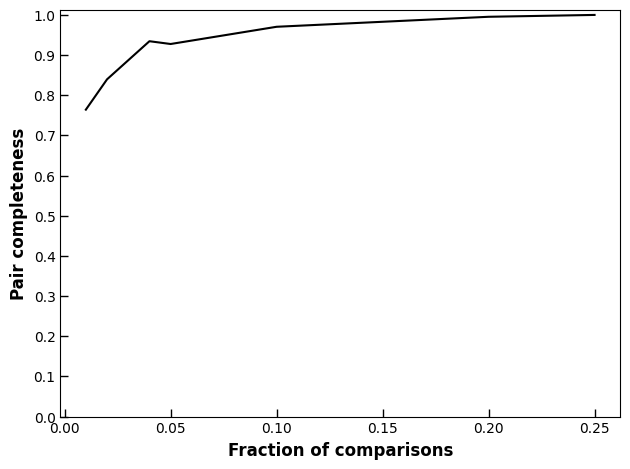

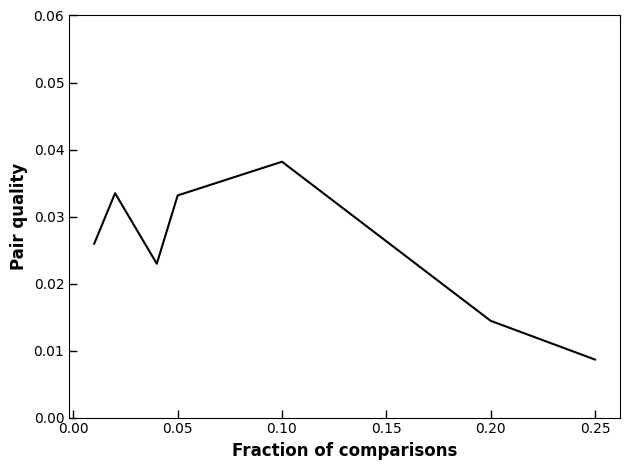

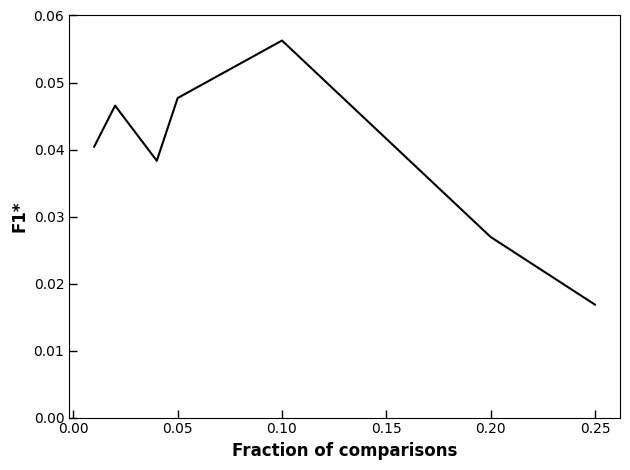

In [ ]:
# Filter data to fractions of comparisons up to 0.30
filtered = final_metrics_df[final_metrics_df['fraction_of_comparisons'] <= 0.30]

# Function to calculate average of top 10 values per fraction of comparisons
def compute_top_10_average(filtered_df, metric_name):
    top_10_avg = (
        filtered_df.groupby('fraction_of_comparisons')[metric_name]
        .apply(lambda x: x.nlargest(5).mean())  # Take the top 5 and compute mean
        .reset_index()
    )
    return top_10_avg

# Compute top 10 averages for each metric
top_10_pc = compute_top_10_average(filtered, 'lsh_pc')
top_10_pq = compute_top_10_average(filtered, 'lsh_pq')
top_10_f1_star = compute_top_10_average(filtered, 'lsh_f1_star')

# Applying Savitzky-Golay smoothing for smoother curves
def smooth_data(x, y):
    if len(y) > 7:  
        return savgol_filter(y, window_length=7, polyorder=2)
    return y  

# Smoothing for each metric
smoothed_pc = smooth_data(top_10_pc['fraction_of_comparisons'], top_10_pc['lsh_pc'])
smoothed_pq = smooth_data(top_10_pq['fraction_of_comparisons'], top_10_pq['lsh_pq'])
smoothed_f1_star = smooth_data(top_10_f1_star['fraction_of_comparisons'], top_10_f1_star['lsh_f1_star'])


tick_params = dict(direction='in', length=6, width=1)

# Plot Pair Completeness (lsh_pc)
plt.figure()
plt.plot(top_10_pc['fraction_of_comparisons'], smoothed_pc, color='black')
plt.xlabel('Fraction of comparisons', fontsize=12, weight='bold')
plt.ylabel('Pair completeness', fontsize=12, weight='bold')
plt.xticks(np.arange(0, 0.30, 0.05), fontsize=10)
plt.yticks(np.arange(0, 1.10, 0.1), fontsize=10)
plt.tick_params(axis='both', **tick_params)  # Inner ticks
plt.tight_layout()
plt.show()

# Plot Pair Quality (lsh_pq)
plt.figure()
plt.plot(top_10_pq['fraction_of_comparisons'], smoothed_pq, color='black')
plt.xlabel('Fraction of comparisons', fontsize=12, weight='bold')
plt.ylabel('Pair quality', fontsize=12, weight='bold')
plt.xticks(np.arange(0, 0.30, 0.05), fontsize=10)
plt.yticks(np.arange(0.00, 0.07, 0.01), fontsize=10)
plt.ylim(0.00, 0.06)  # Set y-axis range for PQ
plt.tick_params(axis='both', **tick_params)  # Inner ticks
plt.tight_layout()
plt.show()

# Plot F1* (lsh_f1_star)
plt.figure()
plt.plot(top_10_f1_star['fraction_of_comparisons'], smoothed_f1_star, color='black')
plt.xlabel('Fraction of comparisons', fontsize=12, weight='bold')
plt.ylabel('F1*', fontsize=12, weight='bold')
plt.xticks(np.arange(0, 0.30, 0.05), fontsize=10)
plt.yticks(np.arange(0.00, 0.07, 0.01), fontsize=10)
plt.ylim(0.00, 0.06)  # Set y-axis range for F1*
plt.tick_params(axis='both', **tick_params)  # Inner ticks
plt.tight_layout()
plt.show()





In [419]:
final_metrics_df["lsh_f1_star"].mean()

np.float64(0.030161552230411663)

## F1 (MSM) evaluation

In [413]:
final_metrics_df["cluster_f1"].max()

np.float64(0.14492753623188404)

## Boostrap for LSH without TF-IDF Preprocessing (Baseline LSH Boostrap Implementation)

In [ ]:
# load_data(df) without TF-IDF preprocessing - regular model words implementation from MSMP+
def load_data(df) -> Tuple[List[Product], np.ndarray]:
    """
    Loads data from the normalized DataFrame and prepares products and duplicates matrix.

    :param df: Normalized DataFrame containing product information.
    :return: A tuple (list of Product objects, duplicates_matrix).
    """
    # Extract products from DataFrame
    products: List[Product] = [
        Product(
            title=row['normalized_title'].replace("/", "").strip(),
            modelID=row['modelID'],
            shop=row['shop'],
            url=row.get('url', ''),  # Handle cases where 'url' may not be present
            featuresMap=row['normalized_features']
        )
        for _, row in df.iterrows()
    ]

    N = len(products)
    duplicates_matrix = np.zeros((N, N), dtype=int)

    for i, p1 in enumerate(products):
        for j, p2 in enumerate(products):
            if i != j and p1.modelID == p2.modelID:
                duplicates_matrix[i, j] = 1

    print(f'\nN={N} products loaded (of which {df["modelID"].nunique()} unique models)\n')
    return products, duplicates_matrix


In [393]:
def main_pipeline_lsh_only(
    df,
    n_bootstraps: int,
    lsh_hash_functions: int,
    shingle_length: int,
    b_values: List[int],
    r_values: List[int]
):
    """
    Main pipeline for LSH-only evaluation across multiple bootstraps.
    """

    products, duplicates_matrix = load_data(df)
    num_products = len(products)
    indices_range = list(range(num_products))

    all_results = []  # Stores metrics for all bootstraps and (b, r) combos

    print("\n--- Starting LSH-Only Bootstrapping Process ---\n")

    for bootstrap_idx in range(n_bootstraps):
        print(f"\nBootstrap {bootstrap_idx + 1}/{n_bootstraps}")

        # Bootstrap sampling
        train_indices = random.choices(indices_range, k=num_products)
        test_indices = list(set(indices_range) - set(train_indices))
        train_products = [products[i] for i in train_indices]
        test_products = [products[i] for i in test_indices]
        train_duplicates_matrix = duplicates_matrix[np.ix_(train_indices, train_indices)]
        test_duplicates_matrix = duplicates_matrix[np.ix_(test_indices, test_indices)]

        # Build TF-IDF and binary vectors for LSH on the training set
        vectorizer, tfidf_matrix = generate_tfidf_matrix(train_products)
        binary_vectors, model_words = preprocess_for_minhashing(train_products)

        for b in b_values:
            for r in r_values:
                if lsh_hash_functions % (b * r) != 0:
                    # Skip invalid combos where b*r doesn't divide the total hash functions
                    continue

                # Compute minhash signatures
                signature_matrix = compute_minhash_from_binary_vectors(
                    binary_vectors,
                    n_hashes=b * r
                )

                # Perform LSH
                candidate_pairs_train = perform_lsh_from_signatures(signature_matrix, num_bands=b)
                fraction_of_comps_train = compute_fraction_of_comparisons(candidate_pairs_train, len(train_products))

                # Evaluate LSH on training data
                lsh_predicted_matrix_train = np.zeros((len(train_products), len(train_products)), dtype=int)
                for (i, j) in candidate_pairs_train:
                    lsh_predicted_matrix_train[i, j] = 1
                    lsh_predicted_matrix_train[j, i] = 1

                lsh_pc_train, lsh_pq_train, lsh_f1_star_train = evaluate_f1_star(lsh_predicted_matrix_train, train_duplicates_matrix)

                # Repeat LSH on test data
                binary_vectors_test, model_words_test = preprocess_for_minhashing(test_products)
                signature_matrix_test = compute_minhash_from_binary_vectors(binary_vectors_test, n_hashes=b * r)
                candidate_pairs_test = perform_lsh_from_signatures(signature_matrix_test, num_bands=b)
                fraction_of_comps_test = compute_fraction_of_comparisons(candidate_pairs_test, len(test_products))

                # Evaluate LSH on test data
                lsh_predicted_matrix_test = np.zeros((len(test_products), len(test_products)), dtype=int)
                for (i, j) in candidate_pairs_test:
                    lsh_predicted_matrix_test[i, j] = 1
                    lsh_predicted_matrix_test[j, i] = 1

                lsh_pc_test, lsh_pq_test, lsh_f1_star_test = evaluate_f1_star(lsh_predicted_matrix_test, test_duplicates_matrix)

                # Store results for training and test sets
                all_results.append({
                    'bootstrap': bootstrap_idx,
                    'b': b,
                    'r': r,
                    'fraction_of_comparisons_train': fraction_of_comps_train,
                    'pair_completeness_train': lsh_pc_train,
                    'pair_quality_train': lsh_pq_train,
                    'f1_star_train': lsh_f1_star_train,
                    'fraction_of_comparisons_test': fraction_of_comps_test,
                    'pair_completeness_test': lsh_pc_test,
                    'pair_quality_test': lsh_pq_test,
                    'f1_star_test': lsh_f1_star_test
                })

    # Compile results into a DataFrame
    results_df = pd.DataFrame(all_results)

    # Compute averages across bootstraps for each (b, r) combination
    averaged_results = results_df.groupby(['b', 'r']).agg({
        'fraction_of_comparisons_train': 'mean',
        'pair_completeness_train': 'mean',
        'pair_quality_train': 'mean',
        'f1_star_train': 'mean',
        'fraction_of_comparisons_test': 'mean',
        'pair_completeness_test': 'mean',
        'pair_quality_test': 'mean',
        'f1_star_test': 'mean'
    }).reset_index()

    print("\n--- Averaged Results Across Bootstraps ---\n")
    print(averaged_results)

    return averaged_results, results_df  # Return both averaged and detailed results



In [ ]:
average_results, detailed_results = main_pipeline_lsh_only(
    df=df,
    n_bootstraps=10,
    lsh_hash_functions=1000,
    shingle_length=3,
    b_values = [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 1000],
    r_values = [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 1000]   
)

In [424]:
average_results["f1_star_test"].mean()

np.float64(0.005250636754938802)